In [1]:
import random

import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf

from CNNModels import SoundClassificationModel
from utils.data_generators import ClassificationDataGenerator

In [2]:
assert tf.test.is_built_with_cuda(), "Установлена CPU версия tensorflow"
assert tf.config.list_physical_devices('GPU'), "Не обнаружено GPU на устройстве"

# Описание решения

Классификация в данной задаче не является сложной задачей для конволюционной нейронной сети. Поэтому, а также с целью снижения нагрузки на вычислительные ресурсы, за основу была вырана легкая архитектура нейросети MobileNetV2, у которой головная часть (head-ер) заменена на несколько  Dense слоев и Dropout для оптимизации и регуляризации процесса обучения. Также, было принято решение использовать претренированную модель нейросети на весах imagenet и использовать метод "fine-tuning" для достижения наилучшей точности.

Данная архитектура нейросети позволила не использовать половину данных для тренировки ("train.part2") и при этом добиться высокой точности на валидационной выборке порядка 95%.

Обучение производилось на видеокарте ноутбука nvidia 1650Ti с 4 гб оперативной памяти. Версия Tensorflow - 2.9.1.

# Конфигурирование

рекомендуемая структура тренировочных данных

```new_folder/
├─ train.part1/
│  ├─ clean/
│  │  ├─ 20/
│  │  ├─ 25/
│  ├─ noisy/
│  │  ├─ 20/
│  │  ├─ 25/
├─ val/
│  ├─ clean/
│  ├─ noisy/


In [3]:
trained_model_filepath = "pretrained_models/classification_clean_noisy"

configs = {
    "image_classes" : ("clean", "noisy"), # классы для классификации

    "training_params" : {
        "input_image_size" : (224, 224, 3), # размер скейлинга изображения перед передачей на вход нейронной сети
        "batch_size" : 8,
        "epochs" : 6,
        "learning_rate":{ # параметры экспоненциального динамического уменьшения learning_rate
            "base_learning_rate" : 0.001,
            "exponential_decay_steps" : 10_000,
            "decay_rate" : 0.9,
        },

        "metrics" : ["accuracy"],
        "pretrained_weights" : "imagenet",
        "N_unfreezed_layers" : 1, # Количество верхних слоев MobileNetV2 для fine-tuning. int, не больше 5
        "shuffle" : True
    },

    "data_folders" : {
        "train" : ["data/train.part1"], # путь до папки с clean/noisy тренировочными данными
        "val" : ["data/val"] # путь до папки с clean/noisy валидационными данными
    }
}

# Загрузка данных

In [4]:
training_params = configs["training_params"]

batch_size = training_params["batch_size"]
input_image_size = training_params["input_image_size"]
image_classes = configs["image_classes"]
shuffle = training_params["shuffle"]

traingen = ClassificationDataGenerator(data_folders=configs["data_folders"]["train"],
                                       batch_size=batch_size,
                                       input_image_size=input_image_size,
                                       image_classes=image_classes,
                                       shuffle=shuffle)
valgen = ClassificationDataGenerator(data_folders=configs["data_folders"]["val"],
                                     batch_size=batch_size,
                                     input_image_size=input_image_size,
                                     image_classes=image_classes,
                                     shuffle=shuffle)

# Тренировка

In [7]:

model = SoundClassificationModel(input_shape=input_image_size,
                                 classes=configs["image_classes"],
                                 pretrained_weights=training_params["pretrained_weights"],
                                 N_unfreezed_layers=training_params["N_unfreezed_layers"])
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=training_params["learning_rate"]["base_learning_rate"],
    decay_steps=training_params["learning_rate"]["exponential_decay_steps"],
    decay_rate=training_params["learning_rate"]["decay_rate"])

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_schedule),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=training_params['metrics'])

mcp_save = tf.keras.callbacks.ModelCheckpoint(trained_model_filepath,
                                              save_format="h5",
                                              save_best_only=True,
                                              monitor='val_loss',
                                              mode='min')

In [6]:
history = model.fit(traingen,
                    validation_data=valgen,
                    callbacks=[mcp_save],
                    epochs=training_params["epochs"])

Epoch 1/6
3000/3000 [==============================] - ETA: 0s - loss: 0.5276 - accuracy: 0.9074

INFO:tensorflow:Assets written to: pretrained_models\classification_clean_noisy\assets


INFO:tensorflow:Assets written to: pretrained_models\classification_clean_noisy\assets


3000/3000 [==============================] - 219s 72ms/step - loss: 0.5276 - accuracy: 0.9074 - val_loss: 0.2358 - val_accuracy: 0.9440
Epoch 2/6
3000/3000 [==============================] - 204s 68ms/step - loss: 0.3547 - accuracy: 0.9262 - val_loss: 0.3430 - val_accuracy: 0.9448
Epoch 3/6
3000/3000 [==============================] - 204s 68ms/step - loss: 0.3440 - accuracy: 0.9308 - val_loss: 0.2681 - val_accuracy: 0.9498
Epoch 4/6
3000/3000 [==============================] - 207s 69ms/step - loss: 0.4180 - accuracy: 0.9293 - val_loss: 0.5248 - val_accuracy: 0.9358
Epoch 5/6
3000/3000 [==============================] - 200s 67ms/step - loss: 0.3577 - accuracy: 0.9342 - val_loss: 0.4112 - val_accuracy: 0.9445
Epoch 6/6
3000/3000 [==============================] - 198s 66ms/step - loss: 0.3764 - accuracy: 0.9339 - val_loss: 0.2720 - val_accuracy: 0.9417


# Статистика по тренировке

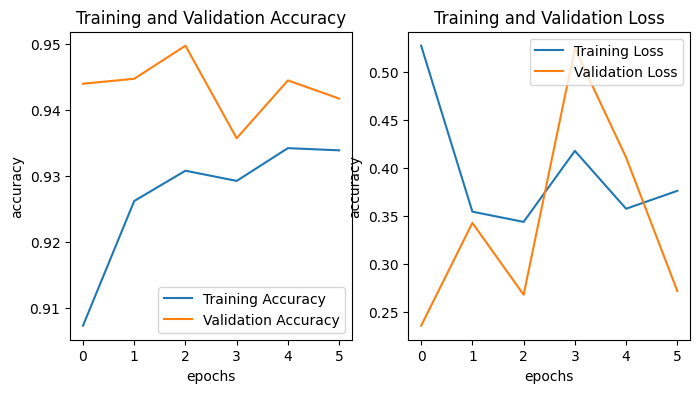

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(training_params["epochs"])

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title('Training and Validation Loss')
plt.show()

С учетом того, что мы использовали "fine-tuning" и не использовывали кросс-валидацию с усреднением по fold-ам, график получился не очень красивый. Темне менее, он позволяет понять, что у нас нет перееобучения.

# Инференс на файле

In [9]:
model.load_weights(trained_model_filepath)

In [11]:
filepath = r"data\train.part1\clean\29\29_123027_29-123027-0007.npy"
model.predict_single_mel_npy_file(filepath)


1/1 [==============================] - 0s 19ms/step


'clean'